# 🎬 Movie Ratings Analysis using TMDB API


This notebook walks through a comprehensive data science project that:
1. Collects top-rated movie data from TMDB API.
2. Performs data cleaning and feature engineering.
3. Explores the data with visualizations.
4. Builds traditional machine learning and deep learning models.
5. Enhances predictions using text-based features from movie overviews.

> Make sure to have your own TMDB API key and install all necessary packages before running.


In [ ]:

import requests
import pandas as pd
import time

API_KEY = "API_KEY"
BASE_URL = "https://api.themoviedb.org/3"

def get_movie_details(movie_id):
    detail_url = f"{BASE_URL}/movie/{movie_id}"
    credits_url = f"{BASE_URL}/movie/{movie_id}/credits"

    try:
        detail_response = requests.get(detail_url, params={"api_key": API_KEY})
        credits_response = requests.get(credits_url, params={"api_key": API_KEY})

        detail_data = detail_response.json()
        credits_data = credits_response.json()

        genres = ", ".join([genre["name"] for genre in detail_data.get("genres", [])])
        runtime = detail_data.get("runtime", None)
        overview = detail_data.get("overview", "")
        director = next((member["name"] for member in credits_data.get("crew", []) if member["job"] == "Director"), None)

        return genres, runtime, director, overview

    except Exception:
        return None, None, None, None

def get_top_rated_movies(pages=5):
    movies = []

    for page in range(1, pages + 1):
        url = f"{BASE_URL}/movie/top_rated"
        params = {
            "api_key": API_KEY,
            "language": "en-US",
            "page": page
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            continue

        data = response.json()
        for movie in data.get("results", []):
            movie_id = movie["id"]
            title = movie["title"]
            print(f"Fetching details for: {title}")
            genres, runtime, director, overview = get_movie_details(movie_id)

            movies.append({
                "Title": title,
                "Rating": movie.get("vote_average"),
                "Votes": movie.get("vote_count"),
                "Release Date": movie.get("release_date"),
                "Popularity": movie.get("popularity"),
                "Genres": genres,
                "Runtime (min)": runtime,
                "Director": director,
                "Overview": overview
            })

            time.sleep(0.3)

    return pd.DataFrame(movies)

# Fetch and save data
df = get_top_rated_movies(pages=5)
df.to_csv("top_rated_movies_with_overviews.csv", index=False)
print("Saved as top_rated_movies_with_overviews.csv")


In [1]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


## 📥 Load the Dataset with Overviews

In [2]:
df = pd.read_csv("top_rated_movies_with_overviews.csv")
df["Overview"] = df["Overview"].fillna("")
df.head()


,Title,Rating,Votes,Release Date,Popularity,Genres,Runtime (min),Director,Overview
0,The Shawshank Redemption,8.712,28476,1994-09-23,27.3180,"Drama, Crime",142,Frank Darabont,Imprisoned in the 1940s for the double murder ...
1,The Godfather,8.687,21569,1972-03-14,29.4449,"Drama, Crime",175,Francis Ford Coppola,"Spanning the years 1945 to 1955, a chronicle o..."
2,The Godfather Part II,8.571,13025,1974-12-20,15.9762,"Drama, Crime",202,Francis Ford Coppola,In the continuing saga of the Corleone crime f...
3,Schindler's List,8.564,16501,1993-12-15,13.1125,"Drama, History, War",195,Steven Spielberg,The true story of how businessman Oskar Schind...
4,12 Angry Men,8.549,9212,1957-04-10,14.9335,Drama,97,Sidney Lumet,The defense and the prosecution have rested an...


## 📊 Data Exploration

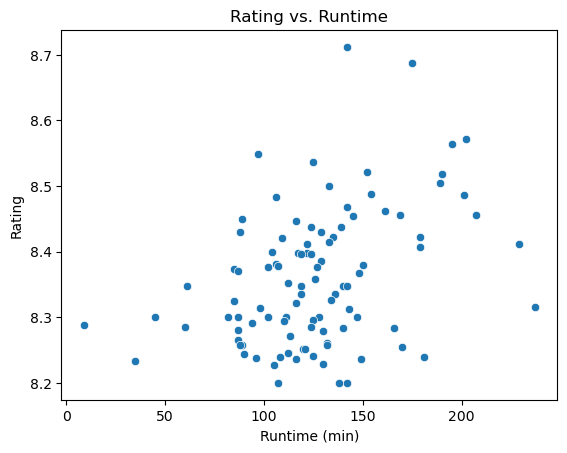

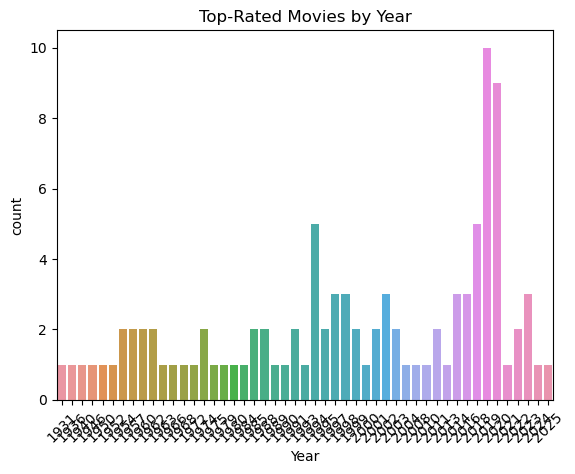

In [3]:
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df["Year"] = df["Release Date"].dt.year

# Runtime vs. Rating
sns.scatterplot(data=df, x="Runtime (min)", y="Rating")
plt.title("Rating vs. Runtime")
plt.show()

# Movies by Year
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Top-Rated Movies by Year")
plt.show()


## ☁️ Word Cloud from Overviews

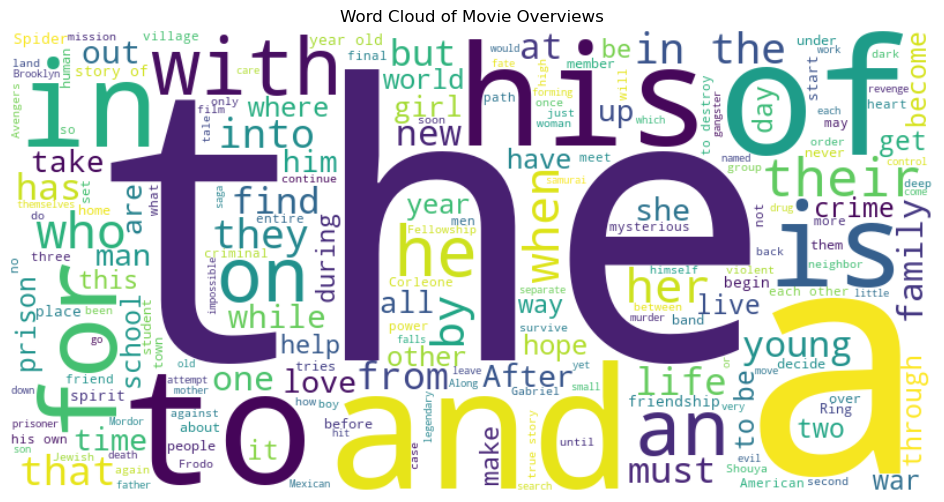

In [4]:
text_all = " ".join(df["Overview"])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords="english").generate(text_all)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Movie Overviews")
plt.show()


## 🧠 Topic Modeling with LDA

In [5]:
tfidf = TfidfVectorizer(stop_words="english", max_features=100)
X_text = tfidf.fit_transform(df["Overview"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_distributions = lda.fit_transform(X_text)

topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(5)])
topic_df.head()


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.058891,0.059611,0.058901,0.057776,0.764822
1,0.061812,0.065772,0.747642,0.062844,0.061931
2,0.072483,0.073919,0.073378,0.708787,0.071433
3,0.058176,0.058349,0.766656,0.058691,0.058128
4,0.058597,0.059060,0.058435,0.058534,0.765374


## 🛠️ Feature Engineering

In [6]:
df["Genre List"] = df["Genres"].fillna("").apply(lambda x: x.split(", "))

# Encode genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df["Genre List"]), columns=mlb.classes_, index=df.index)

# Encode directors
director_counts = df["Director"].value_counts()
valid_directors = director_counts[director_counts >= 2].index
df["Director_Clean"] = df["Director"].where(df["Director"].isin(valid_directors), "Other")

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
director_encoded = pd.DataFrame(
    ohe.fit_transform(df[["Director_Clean"]].fillna("Unknown")),
    columns=ohe.get_feature_names_out(["Director_Clean"]),
    index=df.index
)

# Combine all features
features = pd.concat([
    df[["Runtime (min)", "Votes", "Popularity"]],
    genre_encoded,
    director_encoded,
    topic_df
], axis=1).dropna()

target = df.loc[features.index, "Rating"]


## 📈 Predicting Ratings using XGBoost

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"XGBoost MSE: {mse:.4f}")
print(f"XGBoost R²: {r2:.4f}")


XGBoost MSE: 0.0251
XGBoost R²: -0.9246


## 🤖 Deep Learning Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
dl_model.fit(X_train_dl, y_train_dl, epochs=50, batch_size=8, verbose=0)

dl_preds = dl_model.predict(X_test_dl).flatten()
dl_mse = mean_squared_error(y_test_dl, dl_preds)
dl_r2 = r2_score(y_test_dl, dl_preds)

print(f"Deep Learning MSE: {dl_mse:.4f}")
print(f"Deep Learning R²: {dl_r2:.4f}")


1/1 [==============================] - 0s 66ms/step
Deep Learning MSE: 0.8873
Deep Learning R²: -67.1091
